# MNIST Autoencoder Experiments
** March 2018 **

** Andrew Riberio @ [AndrewRib.com](http://www.andrewrib.com) **

Resources
* https://www.tensorflow.org/get_started/mnist/beginners
* https://blog.keras.io/building-autoencoders-in-keras.html

## 1. Libraries and Config

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import losses
from keras.callbacks import EarlyStopping
from tensorflow.examples.tutorials.mnist import input_data
from keras import backend as K
import tensorflow as tf
from ipywidgets import interact
import pandas as pd
from keras.models import load_model

#### 1.2. Start tensorflow session and have keras use it. 

In [29]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(sess)

## 2. Gathering and Working with MNIST Data

#### 2.1. Loading the dataset object into the mnist variable and printing the dimensions of the data matrix and label vector. 

In [30]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
print("Shape of the image data matrix: {0}".format(mnist.train.images.shape))
print("Shape of the label data: {0}".format(mnist.train.labels.shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of the image data matrix: (55000, 784)
Shape of the label data: (55000,)


####  2.2. Visualizing an image in our training set. 

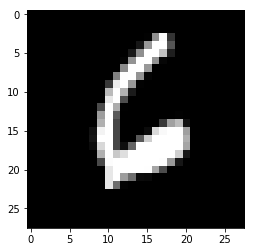

In [31]:
exampleIndex = 3
exImage      = mnist.train.images[exampleIndex ,:]
exImageLabel = mnist.train.labels[exampleIndex]
plt.imshow(exImage.reshape(28,28),cmap='gray')

#### 2.3. Split images into digit class tensors.

In [32]:
# First we will zip the training labels with the training images
dataWithLabels = zip(mnist.train.labels, mnist.train.images)

# Now let's turn this into a dictionary where subsets of the images in respect 
# to digit class are stored via the corresponding key.

# Init dataDict with keys [0,9] and empty lists.
digitDict = {}
for i in range(0,10):
    digitDict[i] = []

# Assign a list of image vectors to each corresponding digit class index. 
for i in dataWithLabels:
    digitDict[i[0]].append(i[1])

# Convert the lists into numpy matricies. (could be done above, but I claim ignorace)
for i in range(0,10):
    digitDict[i] = np.matrix(digitDict[i])
    print("Digit {0} matrix shape: {1}".format(i,digitDict[i].shape))

Digit 0 matrix shape: (5444, 784)
Digit 1 matrix shape: (6179, 784)
Digit 2 matrix shape: (5470, 784)
Digit 3 matrix shape: (5638, 784)
Digit 4 matrix shape: (5307, 784)
Digit 5 matrix shape: (4987, 784)
Digit 6 matrix shape: (5417, 784)
Digit 7 matrix shape: (5715, 784)
Digit 8 matrix shape: (5389, 784)
Digit 9 matrix shape: (5454, 784)


## 3. Anomoly Detection for Non-Zero Class Digits

#### 3.1. Compile a simple single layer non-convolutional autoencoder for the digit class 0. 

In [33]:
def simpleAE(encoding_dim = 32, input_dim = 784):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    return Model(input_img, decoded)

In [34]:
ae1 = simpleAE(32,784)
ae1.compile(optimizer='adadelta', loss='binary_crossentropy')

#### 3.2. Train the autoencoder and log the loss over epoch history. 

Loading model...
Model not found. Training model..
Epoch 1/100
5444/5444 [==============================] - 27s 5ms/step - loss: 0.3117
Epoch 2/100
5444/5444 [==============================] - 2s 344us/step - loss: 0.2216
Epoch 3/100
5444/5444 [==============================] - 2s 337us/step - loss: 0.2002
Epoch 4/100
5444/5444 [==============================] - 2s 339us/step - loss: 0.1890
Epoch 5/100
5444/5444 [==============================] - 2s 373us/step - loss: 0.1801
Epoch 6/100
5444/5444 [==============================] - 2s 377us/step - loss: 0.1724
Epoch 7/100
5444/5444 [==============================] - 2s 337us/step - loss: 0.1659
Epoch 8/100
5444/5444 [==============================] - 2s 324us/step - loss: 0.1607
Epoch 9/100
5444/5444 [==============================] - 2s 326us/step - loss: 0.1563
Epoch 10/100
5444/5444 [==============================] - 2s 361us/step - loss: 0.1525
Epoch 11/100
5444/5444 [==============================] - 2s 345us/step - loss: 0.1488
Ep

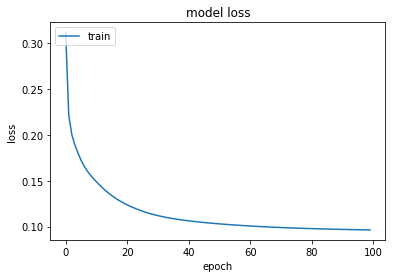

In [35]:
modelURI = "models/mnist_zero_autoencoder_1.h5"

print("Loading model...")

try:
    # Load model if found. 
    ae1 = load_model(modelURI)
    print("Model found and loaded.")
except:
    # Train model if model cannot be loaded. 
    print("Model not found. Training model..")
    
    history = ae1.fit(digitDict[0], digitDict[0],
                    epochs=100,
                    batch_size=20,
                    shuffle=True,verbose=1)
    
    # Save our Model
    print("Model Saved.")
    ae1.save(modelURI)
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### 3.3. Explore trained autoencoder reconstruction results ( Interactive )

In [36]:
def dispRes1(digitClass=0,nthDigit=0):
    actual = digitDict[digitClass][nthDigit,:]
    pred = ae1.predict(actual)
    res = losses.mean_absolute_error(actual,pred)
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Mean Absolute Reconstruction Error: {0:.5}%".format(sess.run(res)[0]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(actual.reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(pred.reshape(28,28),cmap="gray")
    
    plt.show()
    
interact(dispRes1,digitClass=(0,9),nthDigit=(0,1000))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), IntSlider(value=0, description='nthDigit', max=1000), Output()), _dom_classes=('widget-interact',))

<function __main__.dispRes1>

#### 3.4. Reconstruction Error Distributions ( Interactive )
We will now explore the reconstruction error distributions over the digit classes. 

In [37]:
classLosses = []
for digitClass in range(0,10):
    lossTensor = losses.mean_absolute_error(digitDict[digitClass],ae1.predict(digitDict[digitClass]))
    res = sess.run(lossTensor)
    res.sort()
    classLosses.append(res)

In [69]:
def dispDists(digitClass=0):
    l = len(classLosses[digitClass])
    plt.figure(figsize=(6, 6))
    plt.hist(classLosses[digitClass],bins=20,range=(0, 0.125))
    
interact(dispDists,digitClass=(0,9))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.dispDists>

We will now plot the histograms of the reconstruction error distributions over the digit classes.

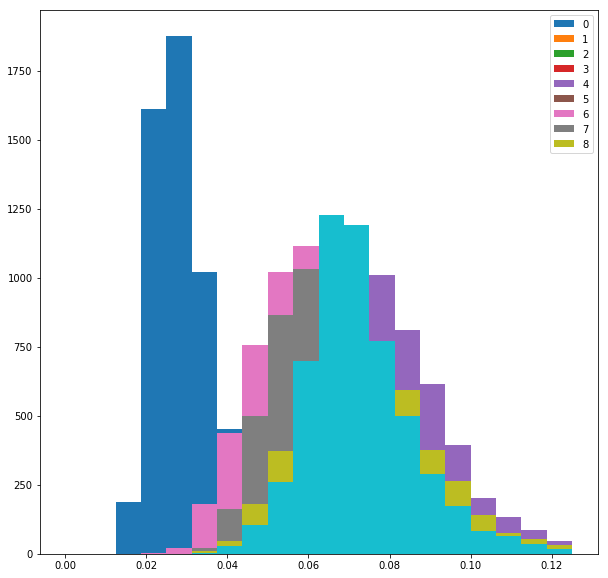

In [52]:
plt.figure(figsize=(10, 10))
for digitClass in range(0,10):
    l = len(classLosses[digitClass])
    plt.legend(['0','1','2','3','4','5','6','7','8','9'], loc='upper right')
    plt.hist(classLosses[digitClass],bins=20,range=(0, 0.125))

In [61]:
# Summary Statistics for Digit Reconstruction Loss
pd.DataFrame(classLosses).transpose().describe()

,0,1,2,3,4,5,6,7,8,9
count,5444.000000,6179.000000,5470.000000,5638.000000,5307.000000,4987.000000,5417.000000,5715.000000,5389.000000,5454.000000
mean,0.029306,0.065315,0.073474,0.064535,0.080972,0.065677,0.059217,0.066122,0.073942,0.072608
std,0.007982,0.013195,0.014789,0.015778,0.014503,0.014142,0.014005,0.014657,0.015745,0.013279
min,0.013538,0.027728,0.027301,0.028797,0.041657,0.030978,0.023682,0.034031,0.022626,0.034732
25%,0.023818,0.056027,0.063047,0.052995,0.071128,0.055990,0.049775,0.055570,0.063044,0.064141
50%,0.027657,0.064640,0.072793,0.062698,0.079034,0.063830,0.057755,0.064310,0.072251,0.070906
75%,0.033150,0.073435,0.082812,0.073633,0.089384,0.073127,0.066631,0.074974,0.083256,0.079083
max,0.082767,0.141858,0.155676,0.154880,0.156735,0.141211,0.147742,0.149392,0.180560,0.142645


#### 3.5. Classify reconstruction loss. 

In [107]:
def simpleNN(encoding_dim = 10, input_dim = 1):

    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(1, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    return Model(input_img, decoded)

In [102]:
zeroClass = classLosses[0]
otherClass = np.concatenate(classLosses[1:10])
labels = np.concatenate([np.zeros(len(zeroClass)),np.ones(len(otherClass))])
data = np.concatenate([zeroClass,otherClass])

In [110]:
snn = simpleNN()
snn.compile(optimizer='adadelta', loss='binary_crossentropy')
snn.fit(data, labels,
                    epochs=100,
                    batch_size=20,
                    shuffle=True,verbose=1)

Epoch 1/100
55000/55000 [==============================] - 17s 301us/step - loss: 0.2888
Epoch 2/100
55000/55000 [==============================] - 3s 63us/step - loss: 0.1461
Epoch 3/100
55000/55000 [==============================] - 4s 64us/step - loss: 0.0870
Epoch 4/100
55000/55000 [==============================] - 4s 66us/step - loss: 0.0729
Epoch 5/100
55000/55000 [==============================] - 5s 98us/step - loss: 0.0674
Epoch 6/100
55000/55000 [==============================] - 4s 68us/step - loss: 0.0649
Epoch 7/100
55000/55000 [==============================] - 4s 71us/step - loss: 0.0634
Epoch 8/100
55000/55000 [==============================] - 4s 77us/step - loss: 0.0625
Epoch 9/100
55000/55000 [==============================] - 4s 72us/step - loss: 0.0619
Epoch 10/100
55000/55000 [==============================] - 4s 72us/step - loss: 0.0615
Epoch 11/100
55000/55000 [==============================] - 4s 73us/step - loss: 0.0611
Epoch 12/100
55000/55000 [=============

In [145]:
def dispRes1(digitClass=0,nthDigit=0):
    classificationThresh = 0.5
    actual = digitDict[digitClass][nthDigit,:]
    pred = ae1.predict(actual)
    res = losses.mean_absolute_error(actual,pred)
    res = sess.run(res)
    
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Mean Absolute Reconstruction Error: {0:.5}%".format(res[0]*100), fontsize=16,y=0.73)
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')
    ax1.set_title("Original Image")
    ax1.imshow(actual.reshape(28,28),cmap="gray")
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")
    ax2.imshow(pred.reshape(28,28),cmap="gray")
    
    plt.show()
    
    snnRes = snn.predict(res)[0][0]
    
    if snnRes < classificationThresh:
        print("Classification 0 : [{0}]".format( snnRes ))
    else:
        print("Classification ANOMALY : [{0}]".format( snnRes ))
        
    
    
    
interact(dispRes1,digitClass=(0,9),nthDigit=(0,1000))

interactive(children=(IntSlider(value=0, description='digitClass', max=9), IntSlider(value=0, description='nthDigit', max=1000), Output()), _dom_classes=('widget-interact',))

<function __main__.dispRes1>